In [83]:
###
#  FUTON Model MDP + Q-Learning Creation Script
#  A Research Project conducted by Noah Dunn 
###

# Import the standard tools for working with Pandas dataframe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shelve
import random
# We want to do type hinting for API clarification
from typing import *
# Import the MDP toolbox that contains a method for conducting Q-Learning
# Tool can be found here: https://github.com/sawcordwell/pymdptoolbox
# Documentation for the tool can be found here 
import mdptoolbox

### Some repetitive type hinting
int_matrix2D = np.array
float_matrix2D = np.array

In [2]:
#  The Data File that will be used to conduct the experiments
patientdata = pd.read_csv("G:/MIMIC-ALL/MIMIC-PATIENTS/patient_data_modified.csv")

In [3]:
### 
#  An MDP, or Markov Decision Process is used to model relationships between various states and actions.
#  A state can be thought of in medical solution as a patient's diagnosis based on current vitals and state of being. 
#  An action can be thought of as a change in current diagnosis based on one of those vitals.
#  The inspirations for the bulk of this code came from Komorowksi's AI Clinician which can be found 
#  here: https://github.com/matthieukomorowski/AI_Clinician/blob/master/AIClinician_core_160219.m
###

###
# Begin by establishing some global variables for use in the MDP creation
###
mdp_count = 500            # The number of repititions we want/count of MDPs we need to create 
clustering_iter = 32       # The number of times clustering will be conducted
cluster_sample = 0.25      # Proportion of the data used for clustering
gamma = 0.99               # How close we desire clusters to be in similarity (Percentage)
transition_threshold = 5   # The cutoff value for the transition matrix
final_policies = 1         # The number of policies we would like to end up with
state_count = 750          # The number of distinct states
action_count = 5           # Number of actions per state (reccommended 2 to 10)
crossval_iter = 10         # Number of crossvalidation runs (Default is 80% Train, 20% Test)

In [4]:
###
# Data structures to hold our interim data
###

# Create the structures and fill them with NaN values
optimal_actions = np.empty((state_count + 2, mdp_count,))  # Not sure the significance of the 2 yet
optimal_actions[:] = np.nan


model_data = np.empty((mdp_count*2, 30,))
model_data[:] = np.nan

bestmodels_data = np.empty((mdp_count, 15))

In [5]:
# Grab list of unique patient ICU stay IDs
icu_ids = patientdata['icustayid'].unique()
# Number of patients to be used for states
id_count = icu_ids.size
print(id_count)

# Create a data structure to representing all patients
patient_idxs = np.empty((id_count, mdp_count,))
patient_idxs[:] = np.nan

21463


In [6]:
# All our columns are broken up into 3 distinct categories:
# 1. Binary values (0 or 1)
# 2. Standard Ranges (Plain old Integers + Decimals)
# 3. Logarthmic Values (columnvalue = log(columnvalue))

colbin = ['gender','mechvent','max_dose_vaso','re_admission', 'qSOFAFlag', 'SOFAFlag']
colnorm = ['age','Weight_kg','GCS','HR','SysBP','MeanBP','DiaBP','RR','Temp_C','FiO2_1',
    'Potassium','Sodium','Chloride','Glucose','Magnesium','Calcium',
    'Hb','WBC_count','Platelets_count','PTT','PT','Arterial_pH','paO2','paCO2',
    'Arterial_BE','HCO3','Arterial_lactate','SOFA','SIRS','Shock_Index','PaO2_FiO2','cumulated_balance', 'qSOFA'];
collog=['SpO2','BUN','Creatinine','SGOT','SGPT','Total_bili','INR','input_total','input_4hourly','output_total','output_4hourly'];

# Create seperate dataframes for each of the columns
colbin_df = patientdata[colbin]
colnorm_df = patientdata[colnorm]
collog_df = patientdata[collog]

# Let's make sure we have what we need
print(colbin_df, "\n", colnorm_df, "\n", collog_df)

        gender  mechvent  max_dose_vaso  re_admission  qSOFAFlag  SOFAFlag
0            0         1            0.0             0          1         0
1            0         1            0.0             0          1         1
2            0         1            0.0             0          1         1
3            0         1            0.0             0          1         1
4            0         1            0.0             0          1         1
...        ...       ...            ...           ...        ...       ...
238325       0         0            0.0             0          1         0
238326       0         0            0.0             0          1         0
238327       0         0            0.0             0          1         0
238328       0         0            0.0             0          1         0
238329       0         0            0.0             0          1         0

[238330 rows x 6 columns] 
                 age  Weight_kg        GCS         HR       SysBP     Me

In [7]:
# Rearrange the dataframe in order of binary, normal, and log data from left to right
MIMIC_raw = pd.concat([colbin_df, colnorm_df, collog_df], axis=1)
print(MIMIC_raw) 

        gender  mechvent  max_dose_vaso  re_admission  qSOFAFlag  SOFAFlag  \
0            0         1            0.0             0          1         0   
1            0         1            0.0             0          1         1   
2            0         1            0.0             0          1         1   
3            0         1            0.0             0          1         1   
4            0         1            0.0             0          1         1   
...        ...       ...            ...           ...        ...       ...   
238325       0         0            0.0             0          1         0   
238326       0         0            0.0             0          1         0   
238327       0         0            0.0             0          1         0   
238328       0         0            0.0             0          1         0   
238329       0         0            0.0             0          1         0   

                age  Weight_kg        GCS         HR  ...    BU

In [8]:
# We want a Z-Score for every item. This a measure of variance to see how far a value is from the mean

# Scipy provides a library to execute this kind of thing
from scipy.stats import zscore
# We need to normalize binaries to -0.5 and 0.5 for later use
MIMIC_zscores = MIMIC_raw

# No need for the zscore algorithm here, -0.5 and 0.5 suffice
MIMIC_zscores[colbin] = MIMIC_zscores[colbin] - 0.5

# Recall these columns are logarithmic, so they needed converted back for proper Z-Scoring (+ 0.1 to avoid log(0))
MIMIC_zscores[collog] = np.log(MIMIC_zscores[collog] + 0.1).apply(zscore)

# Normal column requires no modifications. Z-Scores are calculated as normal
MIMIC_zscores[colnorm] = MIMIC_zscores[colnorm].apply(zscore)
print(MIMIC_zscores)

# We want Re Admission and fluid intake scaled Similarly to the other variables
MIMIC_zscores['re_admission'] = np.log(MIMIC_zscores['re_admission'] + 0.6)
# Apply a scalar to fluid intake
MIMIC_zscores['input_total'] = 2 * MIMIC_zscores['input_total']

        gender  mechvent  max_dose_vaso  re_admission  qSOFAFlag  SOFAFlag  \
0         -0.5       0.5           -0.5          -0.5        0.5      -0.5   
1         -0.5       0.5           -0.5          -0.5        0.5       0.5   
2         -0.5       0.5           -0.5          -0.5        0.5       0.5   
3         -0.5       0.5           -0.5          -0.5        0.5       0.5   
4         -0.5       0.5           -0.5          -0.5        0.5       0.5   
...        ...       ...            ...           ...        ...       ...   
238325    -0.5      -0.5           -0.5          -0.5        0.5      -0.5   
238326    -0.5      -0.5           -0.5          -0.5        0.5      -0.5   
238327    -0.5      -0.5           -0.5          -0.5        0.5      -0.5   
238328    -0.5      -0.5           -0.5          -0.5        0.5      -0.5   
238329    -0.5      -0.5           -0.5          -0.5        0.5      -0.5   

             age  Weight_kg       GCS        HR  ...       BUN 

In [9]:
### The main loop to generate all possible models

num_rows = id_count  # Total Number of Patients to divy data up
testing_flag = 1     # The random number we use to identify a patient used for testing

# TODO: Change this to 1 in MDP_COUNT
#for model in range(1, 2): #mdp_count):
train_ids = []       # A list containing all training ids from the icu_ids list
test_ids =[]         # A list containing all testing ids from the icu_ids list

# We want approximate 20% test, 80% train, so we random numbers 1-5
# 1s Represent data points that will be used to test, 2-5 will be used to train
group_ids = pd.DataFrame([int(np.floor(5 * np.random.random() + 1)) for i in range(1, id_count + 1)])
icu_pair_set = pd.concat([pd.DataFrame(icu_ids), group_ids], axis=1, sort=False)
icu_pair_set.columns = ['id', 'fil_val']
train_ids =  icu_pair_set[icu_pair_set['fil_val'] != testing_flag]
test_ids = icu_pair_set[icu_pair_set['fil_val'] == testing_flag]

# We want to insure that the testing patients + training patients = total patients
if (train_ids['id'].size + test_ids['id'].size) != id_count:
    print("The testing and training set do not add up to the total set")
    exit()

# Percentage for testing should be about 20%, Training about 80%
print("Testing Percentage: " + str((test_ids['id'].size / id_count)))
print("Training Percentage: " + str((train_ids['id'].size / id_count)))

# After grabbing all the IDs, we want to flag all the rows that are train or test
train_flag = patientdata['icustayid'].isin(train_ids['id'])
test_flag = patientdata['icustayid'].isin(test_ids['id'])

import pickle
# Temporarily write train_flag for later use DELETE LATER
with open('sample_train.txt', 'wb') as fp:
    pickle.dump(train_flag, fp)

#Validating that all data is being selected, and that the train and test sets are perfect opposites
if patientdata['icustayid'].size != train_flag.size or not((train_flag.equals(~test_flag))):
    print("Not all rows were grabbed properly, there is something wrong with the split")
    exit()

Testing Percentage: 0.20346643060150027
Training Percentage: 0.7965335693984997


In [10]:
# Seperate the Z-Scores for the training set and the testing set
train_zscores = MIMIC_zscores[train_flag]
test_zscores = MIMIC_zscores[test_flag]

# Validate all data is selected
if(train_zscores.size + test_zscores.size != MIMIC_zscores.size):
    print("The Z-Scores are all evenly distributed")
    exit()

    
# The blocs of relevance in order based on the train and test set
# These will be used to build relevant data frames later down
train_blocs = patientdata[train_flag]['bloc']
test_blocs = patientdata[test_flag]['bloc']

# Doing the same with the patient ids
train_id_list = patientdata[train_flag]['icustayid']
test_id_list = patientdata[test_flag]['icustayid']

# Grabbing the boolean values for the patients who died within 90 days in the training set
train_90d = patientdata[train_flag]['mortality_90d']

In [11]:
# Next, we want to sample the existing training set to only pick cluster_sample percent to use

# We want to flag all the data points in the train_zscores set that will be used to create the MDP

# Note: len(train_zscores.index) is the fastest way to get the number of rows in a dataframe in pandas

# Additional Note: np.floor(np.random.random() + cluster_sample) is a computationally speedy way to get an approximate
# percentage sample from a proportion value (cluster_sample). If cluster sample is 0.25, approximately 25% of the values
# will be flagged as a 1, making it into the sample training set
sample_train_flags = [bool(np.floor(np.random.random() + cluster_sample)) for i in range(len(train_zscores.index))]

# It's good to know how much of the data was selected as sample
print("Proportion of Train Data used for the Sample: " + str(sample_train_flags.count(True)/len(sample_train_flags)))

# The actual set to use
sample_train_set = train_zscores[sample_train_flags]

# Python has object serialization to make write/reads fasters, in the form of pickle
import pickle

# Save the important data (clusters created as a result of the K-Means operations)
# This process takes quite a while. This will provide a checkpoint to decrease compute time
# until the code is put into dev.
with open('train_zscores.txt', 'wb') as fp:
    pickle.dump(train_zscores, fp)

Proportion of Train Data used for the Sample: 0.248785131268933


In [39]:
# Do Not Run the following code block if temporarily troubleshooting
# It takes a long time and there is a checkpoint system in place 
#
#
#
#
#
#
#
#

In [14]:
# In order to prepare a proper set of states, we want to use k-means clustering to group various patients into 
# distinct states based on Z-Scores

# K-Means or K-Means++ is a technique used to condense very diverse and sparse data into similar groups called 'clusters'
# The K-means algorithm will create k clusters from N data points. In the case of this research,
# the algorithm divides patients into groups that have similar data (age, blood pressure, etc..) and creates a faux 'point'
# at the center of that particular clustering of data


# Skikit offers a solution to perform K-Means++ clustering
from sklearn.cluster import KMeans
# The KMeans takes three 'settings' arguments
# 1. n_clusters: The number of clusters (later to be used as states), that we desire the algorithm to produce
# this value has been preset to state_count which is 750
# 2. max_iter: How many times each round of k-means clustering will make adjustments, set at 10,000 in my case
# 3. n_init: The number of max_iter batches that will be conducted in a row. The best of these will be chosen
# and saved in the variable clusters_models
clusters_models = KMeans(n_clusters=state_count, max_iter=10000, n_init=clustering_iter).fit(sample_train_set)
print(clusters_models.labels_)
print(clusters_models.cluster_centers_)

# Python has object serialization to make write/reads fasters, in the form of pickle
import pickle

# Save the important data (clusters created as a result of the K-Means operations)
# This process takes quite a while. This will provide a checkpoint to decrease compute time
# until the code is put into dev.
with open('cluster_labels.txt', 'wb') as fp:
    pickle.dump(clusters_models.labels_, fp)
with open('cluster_centers.txt', 'wb') as fp:
    pickle.dump(clusters_models.cluster_centers_, fp)

[378 276   0 ... 710  32 213]
[[ 0.10714286 -0.25       -0.48863095 ...  0.56706936  0.33430563
   0.51295224]
 [-0.12711864  0.15254237 -0.48248305 ...  0.33433285  0.49417375
   0.52046915]
 [-0.17741935 -0.03225806 -0.44114516 ...  0.55860119  0.02712156
   0.22024834]
 ...
 [-0.12962963  0.24074074 -0.32174074 ...  0.34391029  0.27197835
   0.17247484]
 [-0.33333333 -0.16666667 -0.5        ...  0.37156322  1.41419748
   1.21327498]
 [ 0.16666667 -0.33333333 -0.48838889 ...  0.33468238 -0.36590553
  -0.5111196 ]]


In [12]:
# Python has object serialization to make write/reads fasters, in the form of pickle
import pickle

# Read these values back in from being saved to file
cluster_values = []
cluster_labels = [] 
train_zscores = []

with open ('cluster_centers.txt', 'rb') as fp:
    cluster_values = pickle.load(fp)
with open ('cluster_labels.txt', 'rb') as fp:
    cluster_labels = pickle.load(fp)
with open ('train_zscores.txt', 'rb') as fp:
    train_zscores = pickle.load(fp)
    
print(cluster_values, "\n", "Dimensions: ", len(cluster_values)," x ", len(cluster_values[0]), "\n", train_zscores)

[[ 0.10714286 -0.25       -0.48863095 ...  0.56706936  0.33430563
   0.51295224]
 [-0.12711864  0.15254237 -0.48248305 ...  0.33433285  0.49417375
   0.52046915]
 [-0.17741935 -0.03225806 -0.44114516 ...  0.55860119  0.02712156
   0.22024834]
 ...
 [-0.12962963  0.24074074 -0.32174074 ...  0.34391029  0.27197835
   0.17247484]
 [-0.33333333 -0.16666667 -0.5        ...  0.37156322  1.41419748
   1.21327498]
 [ 0.16666667 -0.33333333 -0.48838889 ...  0.33468238 -0.36590553
  -0.5111196 ]] 
 Dimensions:  750  x  50 
         gender  mechvent  max_dose_vaso  re_admission  qSOFAFlag  SOFAFlag  \
13         0.5      -0.5           -0.5      0.095310       -0.5      -0.5   
14         0.5       0.5           -0.5      0.095310       -0.5      -0.5   
15         0.5       0.5           -0.5      0.095310       -0.5      -0.5   
16         0.5       0.5           -0.5      0.095310       -0.5      -0.5   
17         0.5      -0.5           -0.5      0.095310        0.5      -0.5   
...        .

In [13]:
# We now want to use the clusters to determine their nearest real data point neighbors
# As a visual of this. Suppose we have 4 flags of different colors scattered over a park. The K-Means++ algorithm
# is what planted the flags in the middle of groups of people that are similar. The KNN Search (K nearest neighbor search)
# can be used in MatLab as a simple point finder instead of as a more complicated Supervised Learning algorithm. In Python 
# we can make use of the Vector Quanization (vq) package to assign each point to a centroid
from scipy.cluster.vq import vq
closest_clusters = vq(train_zscores, cluster_values)

# Check to make sure each cluster has a value
print(len(closest_clusters[0]))

# As an aside, closest_clusters[1] contains the distance between each point's values (in this case 50 of them)
# and their closest cluster's values.
# Ex: If a point is [1, 1, 1] and it's closest cluster is the point [3, 3, 3]  closest_clusters[1] would contain the vector
# [abs(3 - 1), abs(3 - 1), abs(3 - 1)] or [2, 2, 2]

# Validate that all the points are in the range 0-749 (since there are only 750 clusters as specified previously)
for i in closest_clusters[0]:
    if(i > 749 or i < 0):
        print("The clusters you are searching for are not configured properly and are out of bounds")
        print("Did you modify the cluster_count variable without changing this error configuration?")
        exit()

190144


In [14]:
### 
#  We want to begin constructing the set of possible actions between states
###

# The number of possible actions is represented as an action_count by action_count matrix
# This is assuming that any action in the list can lead to any other action 
number_actions = action_count * action_count

#  This may prove to be not as useful since this is diagnosis based: extracting information on
#  Fluid input and max dose of vasopressors
iv_fluid = patientdata['input_4hourly']

#  Avoid any fluid that is 0 (That was not administered)
iv_fluid = iv_fluid[iv_fluid > 0]
# Determine minimum and maxium to scale data appropriately
print("Old Lowest IV Fluid Rank: ", min(iv_fluid.rank()))
print("New Highest IV Fluid Rank: ", max(iv_fluid.rank()))
# Now we want to rank these actions in order of their value (lowest to highest)
# We normalize our range from (1.5, 173142.0) to (0, 1)

# Moving the minimum to zero
iv_fluid_ranks = (iv_fluid.rank() - min(iv_fluid.rank()))
# Shifting the max to approximately 1
iv_fluid_ranks = iv_fluid_ranks / max(iv_fluid_ranks)

# Validate that the range is indeed 0 to 1
print("Old Lowest IV Fluid Rank: ", min(iv_fluid_ranks))
print("New Highest IV Fluid Rank: ", max(iv_fluid_ranks))

if round(max(iv_fluid_ranks), 3) != 1 or round(min(iv_fluid_ranks), 3) != 0:
    print("The ranks are not normalized correctly, either the max is too high, or the minium is too low")
    print("Current max: ", round(max(iv_fluid_ranks), 3))
    print("Curret min: ", round(min(iv_fluid_ranks), 3))
    exit()

# This is a mathematics trick to seperate all the values into three distinct groups based on their rank.
# Since ranks are determined based on Vasopressor quantity, the four groups represent the amount of iv fluid
# Administered to a patient (Group 1 - Low, Group 2 - Mid-Low, Group 3 - Mid-High, Group 4 - High)
iv_fluid_groups = np.floor((iv_fluid_ranks + 0.2499999999) * 4)

# Validate that groups are all associated with the numbers 1-4
if not(iv_fluid_groups.isin([1,2,3,4]).any()):
    print("Groups chosen fall outside the desired 1-4 window")
    
# If an IV fluid amount is 0, we denote it to be action 1. 
# If an IV fluid falls into non-zero amounts, we use ranks built above (1 - 4) plus one. Making 
# the subset of these actions to be action 2 thru 5.
# In short, the model can choose to give a 'patient' 5 different IV amounts 
num_of_rows = patientdata['input_4hourly'].size
iv_fluid_actions = pd.Series([1 for i in range(0, num_of_rows)])

# If the value was non-zero and grouped in the 1 - 4 groups, we grab its value to save as an action
for index in iv_fluid_groups.index:
    iv_fluid_actions[index] = iv_fluid_groups[index] + 1

print(iv_fluid_actions)
print(iv_fluid_groups)

Old Lowest IV Fluid Rank:  1.5
New Highest IV Fluid Rank:  173142.0
Old Lowest IV Fluid Rank:  0.0
New Highest IV Fluid Rank:  1.0
0         2
1         3
2         3
3         3
4         2
         ..
238325    1
238326    1
238327    1
238328    1
238329    1
Length: 238330, dtype: int64
0         1.0
1         2.0
2         2.0
3         2.0
4         1.0
         ... 
238319    3.0
238320    4.0
238321    4.0
238322    1.0
238324    2.0
Name: input_4hourly, Length: 173142, dtype: float64


In [15]:
###
# The generate_action_column function takes 4 arguments: 
#
# column_values: A series of column values from a dataframe that we want to turn into action states
# num_groups: How many groups or distinct actions we want to split the data into
# column_name: The name of the column used for print debug statements
# num_rows: The total number of rows in the full column before modifications (This is normally patientdata[column_name].size)
# 
# This function returns column_actions, a series that represents the 'action', or group that each row of data falls under.
#
# An example is found down below, but in words, this function takes a full column of data, groups 
# the values for that data into num_groups distinct actions, and returns a series representing actions based on row
# 
# Ex: Patients' blood pressure might be grouped into 5 categories (Action 1: < 20 mmHg, Action 2: > 20 mmHg && < 60 mmHg... etc)
###

def generate_action_column(column_values, num_groups, column_name, num_rows):
    # Determine minimum and maxium to scale data appropriately
    print("Old Lowest ", column_name, " Rank: ", min(column_values.rank()))
    print("Old Highest " , column_name,  " Rank: ", max(column_values.rank()))
    # Now we want to rank these actions in order of their value (lowest to highest)
    # Normalizing according to lowest and highest rank
    
    # Moving the minimum to zero
    column_ranks = (column_values.rank() - min(column_values.rank()))
    # Shifting the max to approximately 1
    column_ranks = column_ranks / max(column_ranks)

    # Validate that the range is indeed 0 to 1
    print("New Lowest ", column_name, " Rank: ", min(column_ranks))
    print("New Highest ", column_name, " Rank: ", max(column_ranks))

    if round(max(column_ranks), 3) != 1 or round(min(column_ranks), 3) != 0:
        print("The ranks are not normalized correctly, either the max is too high, or the minium is too low")
        print("Current max: ", round(max(column_ranks), 3))
        print("Curret min: ", round(min(column_ranks), 3))
        exit()
    # This is a mathematics trick to seperate all the values into {num_groups} distinct groups based on their rank.
    # Given different columns of interest this can take different forms. For IV fluids, this number is 4.
    column_groups = np.floor(((column_ranks + 1.0/float(num_groups) - 0.000000001) * num_groups))

    # Validate that groups are all associated with desired group split
    if not(iv_fluid_groups.isin([i for i in range(1, num_groups + 1)]).any()):
        print("Groups chosen fall outside the desired 1-4 window")
        exit()
    
    column_actions = pd.Series([1 for i in range(0, num_rows)])

    # If the value was non-zero and grouped in the 1 - 4 groups, we grab its value to save as an action
    for index in column_groups.index:
        column_actions[index] = column_groups[index] + 1

    #print(column_actions)
    #print(column_groups)
    return column_actions
    

In [16]:
# This small sample insures the function performs the same as the test conducted above for IV Fluid
iv_fluid = patientdata['input_4hourly']
iv_fluid = iv_fluid[iv_fluid > 0]

test_column = generate_action_column(iv_fluid, 4, "IV Fluid", patientdata['input_4hourly'].size)

print(test_column.equals(iv_fluid_actions))

Old Lowest  IV Fluid  Rank:  1.5
Old Highest  IV Fluid  Rank:  173142.0
New Lowest  IV Fluid  Rank:  0.0
New Highest  IV Fluid  Rank:  1.0
True


In [17]:
# Now we want the exact same thing but done with given Vasopressor amounts
vasopressor_administered = patientdata['max_dose_vaso']
vasopressor_administered = vasopressor_administered[vasopressor_administered > 0]

vasopressor_actions = generate_action_column(vasopressor_administered, 4, "Max Dose Vasopressor", patientdata['max_dose_vaso'].size)
print(vasopressor_actions.unique())

Old Lowest  Max Dose Vasopressor  Rank:  1.0
Old Highest  Max Dose Vasopressor  Rank:  35503.0
New Lowest  Max Dose Vasopressor  Rank:  0.0
New Highest  Max Dose Vasopressor  Rank:  1.0
[1 5 3 4 2]


In [18]:
###
# This function takes two arguments:
# actions_column: A column of action groups generated by the above function (generate_action_column())
# real_values: The actual values from the dataset corresponding to the same column as actions_column
# and returns a list that contains the real median values for each 'group' actions.
#
# Ex: We apply the function to the action_column "IV_Fluid", which has split the data into 4 different groups of 
# IV_Fluid actions. This function will produce a list containing the median amount of IV_Fluid administered for each of those
# groups (Group 1 -> Adminster 20 mL, Group 2 -> Administer 40 mL, Group 3 -> Administer 60 mL, Group 4 -> Administer 80 mL
###

def median_action_values(actions_column, real_values):
    # Grab all the unique actions for a column and sort them
    all_groups = np.sort(actions_column.unique())
    # Concatanate the group number and real value for each row
    action_set = pd.concat([actions_column, real_values], axis=1, sort=False)
    # Name the columns for accurate querying
    action_set.columns = ['group_id', 'data_val']
    # Grab the median value for each group based on group number using python list comprehension
    median_values = [np.median(action_set[action_set['group_id'] == i]['data_val']) for i in all_groups]
    return median_values


In [19]:
iv_median_actions = median_action_values(iv_fluid_actions, patientdata['input_4hourly'])
vasopressor_median_actions = median_action_values(vasopressor_actions, patientdata['max_dose_vaso'])
print("IV Action Median Values:", str(iv_median_actions), "\nVasopressor Action Median Values: ", vasopressor_median_actions, "\n")

IV Action Median Values: [0.0, 30.0, 80.66666667, 308.0, 955.5037749999999] 
Vasopressor Action Median Values:  [0.0, 0.04, 0.135, 0.27, 0.7625] 



In [20]:
### 
# This function takes one argument
# list_action_columns: This is a Pandas dataframe that contains all the action_columns we desir to be grouped by index
# This can be retrieving using the previously defined 'median action' function 
# 
# and returns two items:
# list_action columns: The 'keys' or integers that represent every permutation of actions
# chosen_action: The key that was chosen based on the action values in each column
### 
def generate_action_matrix(list_action_columns):
    # Grabs the list of columns the user has provided for use
    desired_columns = [column for column in list_action_columns]
    # Drops all group combinations that are duplicates
    list_action_columns_indexes = list_action_columns.drop_duplicates(desired_columns)
    # Sorts all combinations in order
    list_action_columns_indexes = list_action_columns_indexes.sort_values(desired_columns)
    # Create a dictionary based on the values from the dataframe 
    list_action_columns_indexes = list_action_columns_indexes.values.tolist() 
    # Determine which index in the list each row corresponds to 
    # Ex: For an 2-D action permutation list of [1,1] thru [5,5], there are 5 x 5 possibilities
    # {1..5}, {1..5}, so there are 25 possible permutations, the indexes will run 1 - 25
    chosen_action = [list_action_columns_indexes.index(val_pair) for val_pair in list_action_columns.values.tolist()]
    # Return the keys first, and then the true values for the dataset
    return list_action_columns_indexes, chosen_action
    

Text(0.5, 0, 'Index of Action Chosen: 1 through 24')

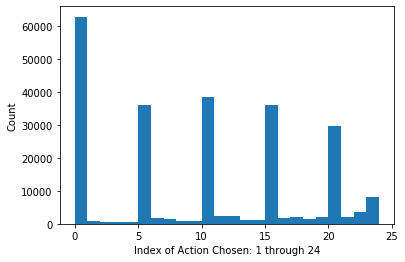

In [21]:
###
# FINISH CONSTRUCTION OF ALL ACTIONS AND THEIR VALUES
###

# Combine the columns that we desire to observe (iv_fluid_actions, vasopressor_actions)
iv_vaso_groups = pd.concat([iv_fluid_actions, vasopressor_actions], axis=1, sort=False)
# Name the columns for proper usage in the function
iv_vaso_groups.columns = ['iv_group', 'vasopressor_group']

action_keys, action_list = generate_action_matrix(iv_vaso_groups)

# Plot the distribution of actions
plt.hist(action_list, density=False, bins=24)  # `density=False` would make counts
plt.ylabel("Count")
plt.xlabel("Index of Action Chosen: 1 through 24")

In [22]:
# Python has object serialization to make write/reads fasters, in the form of pickle
import pickle
train_chosen_actions = []
with open ('sample_train.txt', 'rb') as fp:
    train_chosen_actions = pickle.load(fp)

# Grab a Series representing the action taken by the train data only
train_chosen_actions = pd.Series(action_list)[train_chosen_actions]

# Assign all action choices to their corresponding median values as shown previously
print(iv_median_actions, vasopressor_median_actions)

# Itertools provides an easy way to perform Cartesian product on multiple sets
from itertools import product as cartesian_prod

# This gives us the representative median values for a patient's vitals present in various action groups
# action_keys[i] corresponds to train_action_values[i]
# So, if the patient falls into group [1, 1] or no iv fluid given, no vasopressor administered,
# The corresponding median values for this group will be represented by train_action_values (0.0, 0.0).
# A patient in group [1, 2] (no iv fluid, a little vasopressor) will have a median real value of (0.0, 0.04)
train_action_values = list(cartesian_prod(iv_median_actions, vasopressor_median_actions))

if len(train_action_values) != len(iv_median_actions) * len(vasopressor_median_actions):
    print("Something went wrong in determining the Cartesian product")
    exit()

[0.0, 30.0, 80.66666667, 308.0, 955.5037749999999] [0.0, 0.04, 0.135, 0.27, 0.7625]


In [23]:
###
# BEGIN CONSTRUCTION OF PRE-STATE MATRIX
# This will be used to build the full state/action matrix
### 

# Based on whether or not a patient is dead, we establish the range of possible values:
# If they have died, the range is [-100, 100]
# If they are alive, the range is [100, -100]
range_vals = [100, -100]
# Convert the range of values for a patient's status (dead or alive) from 0 or 1 to -1 or 1
# This will enable ranges to suit the above criteria [-100, 100] or [100, -100]
train_90d_polarity = (2 * (1 - train_90d) - 1)
range_matrix = [np.multiply(polarity, range_vals) for polarity in train_90d_polarity]
# Grab the lower range limit and upper range limit seperately in order to build the 
all_lower_ranges = [i[0] for i in range_matrix]
all_upper_ranges = [i[1] for i in range_matrix]
# The qlearning_dataset prior to modification contains 6 columns and ~190885 rows (around 75% of the data)
# The columns are as follows:
#
# training_bloc: time_series stamps for a patient's state over time, very in range from {1..?}
#
# closest_cluster_index: The index of the nearest cluster to the z-scores of the patient's data, 
# corresponding actual data for each cluster's index (i) can be found in cluster_values[i]
#
# chosen_action_index: The chosen action or representation of a patient's IV_Fluid and Vasopressor status [0 - 24]
# 
# 90d_mortality_status: 0 means the patient is alive 90 days after discharge from ICU
#                      1 means the patient is dead  90 days after discharge from ICU
#
# lower_range + upper_range: An index to be used later on, gathered from the range index
print("Training Blocs Length: ", len(train_blocs), "Closest Clusters Length: ", len(closest_clusters[0]), "Action List Length: ", len(train_chosen_actions), "Train 90d Length", len(train_90d), "Range Matrix Length: ", len(range_matrix))
qlearning_dataset = pd.concat([pd.Series(train_blocs.tolist()), 
                               pd.Series(closest_clusters[0]), 
                               pd.Series(train_chosen_actions.tolist()), 
                               pd.Series(train_90d.tolist()), 
                               pd.Series(all_lower_ranges), 
                               pd.Series(all_upper_ranges)], 
                              axis=1, sort=False)
qlearning_dataset.columns = ['training_bloc', 'closest_cluster_index', 'chosen_action_index', '90d_mortality_status', 'lower_range', 'upper_range']
print(qlearning_dataset)

Training Blocs Length:  190144 Closest Clusters Length:  190144 Action List Length:  190144 Train 90d Length 190144 Range Matrix Length:  190144
        training_bloc  closest_cluster_index  chosen_action_index  \
0                   1                     81                    0   
1                   2                    105                    0   
2                   3                    105                    0   
3                   4                    105                    0   
4                   5                    105                    0   
...               ...                    ...                  ...   
190139              9                    610                    0   
190140             10                     31                    0   
190141             11                    213                    0   
190142             12                    315                    0   
190143             13                    315                    0   

        90d_mortality_stat

In [24]:
# The base qlearning_dataset does not account for endpoints in either life or death
# These states have not been established yet, which is what this step corrects
qlearning_dataset_len = len(qlearning_dataset.index)
# We need space to add a death/life state for every patient, about a 20% increase in size from the original MDP
# We will cut the excess off by the end of the loop
qlearning_dataset_len_mod = int(np.floor(qlearning_dataset_len * 1.2))
qlearning_dataset_mod = np.array([[0 for i in range(0, 4)] for i in range(0, qlearning_dataset_len_mod)])

# Start construction of modified data
row = 0
# In Markov theory, an absorbing state is one which can be entered, but cannot be left. (Similar to the Hotel California)
# In the case of this experiment, those states are either life (state_count) or death (state_count + 1) per patient as
# defined by me
absorbing_states = [state_count, state_count + 1]

# Start the loop to begin capping the markov chain off at life and death states
for i in range(0, qlearning_dataset_len - 1):
    # Use the already gathered data for each row
    qlearning_dataset_mod[row, :] = qlearning_dataset.iloc[i][0:4]
    # If we arrive at the terminal point (end of patient data), we need to point the MDP to either the death or life state
    if qlearning_dataset.iloc[i + 1]['training_bloc'] <= qlearning_dataset.iloc[i]['training_bloc']:
        # Grab the row
        whole_row = qlearning_dataset.iloc[i]
        # Set most of the row to the original data's values, except set the action to be either state 750 or 751
        # Life or death respectively
        row = row + 1
        # We need bloc number, final state (life or death, 750 or 751), end action (-1), and the reward value (lower_range)
        qlearning_dataset_mod[row, :] = [whole_row['training_bloc'] + 1, absorbing_states[whole_row['90d_mortality_status']], 25,  whole_row['lower_range']]
    row = row + 1
# Add in the last row
whole_row = qlearning_dataset.iloc[len(qlearning_dataset.index) - 1]
qlearning_dataset_mod[row, :] = [whole_row['training_bloc'] + 1, absorbing_states[whole_row['90d_mortality_status']], 25,  whole_row['lower_range']]
row = row + 1
# Get rid of the unneeded rows
qlearning_dataset_mod = pd.DataFrame(qlearning_dataset_mod[0:row, :])
qlearning_dataset_mod.columns = ['training_bloc', 'closest_cluster_index', 'chosen_action_index', 'reward_value']

In [25]:
# Total patients being observed in the test
print(len(qlearning_dataset_mod[qlearning_dataset_mod['training_bloc'] == 1]['training_bloc']))
# Show that we now have end states established 
print(len(qlearning_dataset[qlearning_dataset['chosen_action_index'] == 25]['chosen_action_index']))
print(len(qlearning_dataset_mod[qlearning_dataset_mod['chosen_action_index'] == 25]['chosen_action_index']))
print(len(qlearning_dataset_mod[qlearning_dataset_mod['closest_cluster_index'] == 750]['chosen_action_index']))
print(len(qlearning_dataset_mod[qlearning_dataset_mod['closest_cluster_index'] == 751]['chosen_action_index']))

17096
0
17096
13123
3973


In [218]:
###
#  Now that we officially have some a valid bloc for actions, and a valid set of states, it's time 
#  to begin building the transitions matrix.
### 

### If the matrix is bidirectional (S1 -> S2, S2 -> S1 are both valid, we can build two matrices)

### 
# The MDP Toolbox we are going to be using requires Transition and Reward Matrices to be in the form
# M(action, state1, state2)
###

###
# The create_transition_matrix method takes 4 arguments:
# num_actions: The total number of possible actions (calculated by action_count ^ 2 or in py, action_count ** 2)
# num_states:  Number of states the model uses
# qlearning_dataset: The dataset that will be used for the qlearning process
# transition_threshold: How many actions do we want to deem as scarce and not worth keeping (default = 5)
# reverse: If false, the matrix that is created is represented as transition[A][S1][S2], if true: transition[A][S2][S1]
###
def create_transition_matrix(num_actions, num_states, ql_data_input, transition_threshold = 5, reverse = False):
    # The transition matrix is a 3D construct, involving a transition between two states
    # and an action. The dimensions for the matrix are (state_count * 2) * (state_count + 2) * action_count
    transition_matrix = [[[0 for i in range(0, num_states + 2)] for i in range(0, num_states + 2)] for i in range(0, num_actions)]
    # NP Arrays allow for more compact and efficient slicing
    transition_matrix = np.array(transition_matrix).astype(float)
    # We also need a matrix to denote the policy that corresponds with taken a particular action from a state
    transition_policy_count = [[0 for i in range(0, num_states + 2 )] for i in range(0, num_actions)]
    transition_policy_count = np.array(transition_policy_count).astype(float)
    # Iterate over the actual data in order to form the actual states and their corresponding actions
    # As soon as we hit the next patient (the next row has a training bloc value of 1), we stop processing actions for that patient
    for i in range(0, len(qlearning_dataset_mod) - 1):
        # Since 1 is our 'endpoint' for each patient, there are no actions we can take from this point on
        if ql_data_input.iloc[i + 1]['training_bloc'] > ql_data_input.iloc[i]['training_bloc']:
            S1 = ql_data_input.iloc[i]['closest_cluster_index']
            S2 = ql_data_input.iloc[i + 1]['closest_cluster_index'] 
            action_id = ql_data_input.iloc[i]['chosen_action_index']
            if not(reverse):
                # Count the number of times S1 -> S2 is taken using action A
                transition_matrix[action_id][S1][S2] = transition_matrix[action_id][S1][S2] + 1
            else:
                # Count the number of times S1 -> S2 is taken using action A
                transition_matrix[action_id][S2][S1] = transition_matrix[action_id][S2][S1] + 1
                
            # Count the number of times action A is used to transition from S1
            transition_policy_count[action_id][S1] = transition_policy_count[action_id][S1] + 1        

    # In order to avoid drastically altering our model, we fix a constant
    # value (set by default to 5), in order to declare sparse actions 
    # as essentially not happening (make their count 0)
    for i in range(0, num_actions):
        for j in range(0, num_states + 2):
            if transition_policy_count[i][j] <= transition_threshold:
                transition_policy_count[i][j] = 0 
    # Now, we want to prevent transitions from state -> state using
    # a certain action if that action is sparse or nonexistant
    for i in range(0, num_actions):
        for j in range(0, num_states + 2):
            if not(reverse):
                # Declare the weight of an unachievable action to have a zero probability
                if transition_policy_count[i][j] == 0:
                    transition_matrix[i,j,:] = 0
                    # All probabilities must be declared, even unreachable states, an easy work around 
                    # to this issue is to simply declare the same state to have a probability of 1
                    # https://stackoverflow.com/questions/43665797/must-a-transition-matrix-from-a-markov-decision-process-be-stochastic
                    transition_matrix[i,j,j] = 1
                # This weights the MDP based on the probability of taking one action from a state
                # As opposed to taking any other possible action from that state
                # S1 -> S2 might be 50%, S1 -> S3 20%, and S1 -> S4 30%
                else:
                    transition_matrix[i,j,:] = transition_matrix[i,j,:]/np.float64(transition_policy_count[i][j])
            else:
                # Declare the weight of an unachievable action to have a zero probability
                if transition_policy_count[i][j] == 0:
                    transition_matrix[i,:,j] = 0
                    # All probabilities must be declared, even unreachable states, an easy work around 
                    # to this issue is to simply declare the same state to have a probability of 1
                    # https://stackoverflow.com/questions/43665797/must-a-transition-matrix-from-a-markov-decision-process-be-stochastic
                    transition_matrix[i,j,j] = 1
                # This weights the MDP based on the probability of taking one action from a state
                # As opposed to taking any other possible action from that state
                # S1 -> S2 might be 50%, S1 -> S3 20%, and S1 -> S4 30%
                else:
                    transition_matrix[i,:,j] = transition_matrix[i,:,j]/np.float64(transition_policy_count[i][j])
    
    # Ensure no divisions create NaNs or infinities
    transition_matrix = np.nan_to_num(transition_matrix)
    # Determine the phyisican's policy based on total count
    # This comes in handy later when comparing model ability
    total_transitions = sum(transition_policy_count)
    print(total_transitions)
    physician_policy = np.divide(transition_policy_count, total_transitions)
    return transition_matrix, physician_policy

In [219]:
# Constructing Transition Matrix(A, State1, State2)
total_actions = action_count ** 2        
# Execute the function call
transition_mat, physician_policy = create_transition_matrix(total_actions, state_count, qlearning_dataset_mod, transition_threshold, False)
# Should be 25, 752, 752
print(len(transition_mat), len(transition_mat[0]), len(transition_mat[0][0]))

[303. 488. 282. 145. 202. 240. 218. 235. 227. 269. 256. 265. 257.  39.
 249. 216. 335.   0. 419.   0.   0. 154. 424. 305. 342. 117. 209.   0.
 519.  30. 233. 304. 391. 238. 425. 125. 157.  74. 160. 489. 142. 344.
 297. 433. 198. 182. 239. 259. 110. 209. 225. 266.  20.  31. 423. 174.
 160. 420. 453.  14. 215. 311. 490. 355. 309.  29. 358. 210. 460. 379.
   8. 236. 245.   9. 329. 326. 347.   0. 308. 212. 165. 209. 449. 180.
  78. 277. 103. 263. 415. 165. 436. 281. 251. 482. 404. 300.   0.  83.
 338. 173. 133. 419.   7.  17. 146. 210.  93. 188. 272. 512. 143. 177.
 430. 166. 282.   6.  14. 488. 299. 292. 191. 304. 381. 239. 203.  61.
 381. 352. 607.  98. 196. 403. 348. 223. 206. 279. 641. 343.  67. 208.
 104.  93. 510. 405. 264. 298.  82. 298. 234. 370. 220. 199. 350. 276.
 448. 351. 399. 149. 303. 226.  81. 308. 249. 247. 241. 517. 162. 259.
 348. 372. 130. 435. 294. 130. 143. 265. 426. 387. 157.  23. 209. 155.
  16. 234. 333. 250.  95. 304. 242. 285. 695. 142. 315. 234. 254.  13.
  37. 

G:\anaconda\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide


In [53]:
# Evaluate whether or not the Sum of all actions from a given state is either 0.0 or 1.0
# Where 1 indicates there are further actions to take, and 0 means we have hit the end of potential actions to take
for i in range(0, 25):
    for j in range(0, 752):
        total_prob = sum(transition_mat[i][j])
        if (abs(total_prob - 1.0) > 0.001):
            print("All probabilities should be either 0.0 or almost 1.0 (0.999....), check your arguments to transition_mat")

In [223]:
# Evaluate whether or not the total sum of all physician policy probabilities 
# is 1
for i in range(0, 752):
    total_prob = 0
    for j in range(0, 25):
        total_prob = total_prob + physician_policy[j][i]
    if (abs(total_prob - 1.0) > 0.001):
            print("One of your states does not have an added action probability total of 1")


In [30]:
# State 750 is life, State 751 is death
# This provides a count of how many states in the finalized MDP end in life and death
life_count = 0
death_count = 0

for i in range(0, total_actions):
    for j in range(0, state_count + 2):
        if transition_mat[i, j, 750] != 0:
            life_count = life_count + 1
        if transition_mat[i, j, 751] != 0:
            death_count = death_count + 1

print("Life Endpoints:", life_count, "\nDeath Endpoints", death_count)

Life Endpoints: 2878 
Death Endpoints 1913


In [31]:
# With the MDP built and the probabilities evaluated, it is time to construct the reward matrix 
reward_mat = np.array([[[0 for i in range(0, state_count + 2)] for i in range(0, state_count + 2)] for i in range(0, total_actions)])
# We want to fix initial penalities and rewards like before at -100 and +100
# Note, we allot the 2 extra columns for the reward and penalty
for i in range(0, total_actions):
    for j in range(0, state_count + 2):
        # If the patient hits the final state of death, we penalize the model
        reward_mat[i][j][state_count] = -100
        # If the patient hits the final state of life, we reward the model
        reward_mat[i][j][state_count + 1] = 100

In [32]:
# Perform Matrix multiplication to multiply reward value by probability of that reward
# This gives us the 'real reward' where sparse events are not weighted as heavily 
# as more frequent events.
# I.E
# An action that occurs 2% of the time resulting in death should suffer a much lower penalty than a death route that occurs 50% of the time
# Likewise, an action occurs 80% of the time yielding life should be looked at more closely than a 2% chance
# an action that incurse a 2%
reward_mat_final = np.multiply(transition_mat, reward_mat)

reward_count = 0
for i in range(0, total_actions):
    for j in range(0, state_count + 2):
        for k in range(0, state_count + 2):
            if reward_mat_final[i][j][k] != 0:
                reward_count = reward_count + 1
# Reward Count should be somewhere in the 2000 - 3500 count
print(reward_count)
            

# Validate that all rewards are in the range -100 to 100 
for i in range(0, total_actions):
    for j in range(0, state_count + 2):
        for k in range(0, state_count + 2):
            if reward_mat_final[i][j][k] > 100 or reward_mat_final[i][j][k] < -100:
                print("The entry at", i + "," + j, "has a reward value of ", reward_mat_other[i][j], "which is not in the range (-100, 100)")
                exit()

4791


In [33]:
###
#  The Full MDP is now finished. The Transition Matrix exists, the reward matrix that corresponds to it also exists.
#  Now is the time to actually perform Q-Learning
###

# The initial MDP matrix
# We need the values of weights that determines how much the model
# prefers transitioning from one state (medical conditional), to another
# The Matrix must be in the form [[A][S1][S2]] Where S1 is initial state, S2 is the second state, and
# A is the action taken to get from S1 to S2. 
transitions = transition_mat

# We need to determine the reward value for predicting an outcome leading to survival (+)
# and a penalty for an outcome that will yield death (-)
# The Matrix must be in the form [[R][S1][S2]] Where S1 is initial state, S2 is the second state, and
# R is the reward for taking the action from S1 to S2. 
reward = reward_mat_final

# We need to determine the discount value to influence the model to continue changing
# when outcomes are not desired, This value should be kept in the range 0 < discount < 1
discount = 0.99

# The Q-Learning algorithm will run a fixed number of times
numOfIterations = 200000

# We need to determine whether or not we want to validate that the transitions and rewards matrix
# to make sure they are valid, this option will only be turned off for speed
scheck = False

In [34]:
# MDP Toolbox (Built originally in MatLab) offers a nice way to perform Q-Learning on an Already Built MDP 
import mdptoolbox
ql_runner = mdptoolbox.mdp.QLearning(transitions, reward, discount, n_iter= numOfIterations)
ql_runner.run()
ql_runner.Q

array([[-2.91751137e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.84169806e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.43960919e-12,  9.58601868e-05,  0.00000000e+00],
       [-3.40282928e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.65203307e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 1.78841927e-01,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.18462983e+03, -1.18480049e+03, -1.18479945e+03, ...,
        -1.18479700e+03, -1.18479779e+03, -1.18480019e+03],
       [ 6.23430245e+03,  1.24526220e+03,  1.27067109e+03, ...,
         1.38142032e+03,  1.24214470e+03,  1.18223197e+03]])

In [35]:
# Given that the Q-Learning has taken place, we can record the best action
# For each state
optimal_actions = [0 for i in range(0, len(ql_runner.Q))]
for i in range(0, len(ql_runner.Q)):
    optimal_actions[i] = np.argmax(ql_runner.Q[i])
print(optimal_actions)

[3, 10, 1, 0, 12, 1, 0, 8, 1, 0, 0, 1, 23, 0, 20, 0, 15, 0, 20, 0, 0, 0, 5, 0, 1, 5, 0, 0, 1, 0, 5, 0, 0, 0, 0, 15, 0, 0, 0, 0, 0, 20, 5, 5, 0, 0, 0, 15, 0, 1, 20, 24, 1, 0, 21, 18, 13, 6, 0, 0, 0, 0, 22, 15, 15, 1, 0, 6, 17, 5, 0, 0, 15, 1, 1, 21, 15, 0, 10, 5, 0, 0, 0, 0, 0, 0, 1, 5, 15, 0, 18, 10, 0, 2, 0, 20, 0, 0, 20, 0, 0, 20, 0, 0, 5, 1, 10, 0, 21, 0, 20, 0, 1, 0, 0, 0, 23, 21, 4, 0, 5, 0, 1, 20, 5, 0, 0, 10, 8, 0, 0, 22, 10, 0, 0, 0, 23, 0, 1, 0, 1, 0, 0, 0, 0, 20, 0, 10, 10, 10, 1, 20, 0, 2, 24, 1, 10, 0, 0, 17, 0, 10, 0, 20, 21, 1, 0, 1, 15, 20, 20, 10, 2, 0, 15, 23, 4, 2, 1, 0, 12, 0, 0, 5, 0, 13, 1, 11, 0, 24, 5, 14, 1, 0, 10, 0, 5, 0, 12, 0, 0, 24, 0, 0, 21, 20, 23, 20, 0, 15, 0, 0, 2, 21, 18, 7, 22, 0, 0, 20, 0, 0, 0, 10, 6, 20, 0, 0, 7, 1, 11, 20, 13, 23, 0, 10, 0, 0, 1, 15, 24, 10, 16, 23, 0, 19, 0, 0, 5, 1, 0, 1, 18, 0, 1, 0, 20, 24, 0, 10, 0, 0, 10, 0, 10, 0, 0, 11, 1, 0, 1, 0, 1, 0, 20, 0, 1, 7, 15, 22, 0, 17, 0, 0, 20, 0, 15, 0, 0, 0, 1, 0, 10, 22, 5, 1, 0, 21, 24, 

In [36]:
# This displays the number of actions in which the optimal action to state
# is not zero. In one run, the original set had 578/750 as non zero. Do 
# to seeding and random number generation, the Q-Learning can differentiate.
total_count = 0 
for i in range(0, 752):
    if optimal_actions[i] != 0:
        total_count = total_count + 1
print(total_count)

423


In [37]:
####
# Q-Learning validation using the Q Model, and the Train and Test sets
####

# We have the optimal actions determined by the Q-Equation, as to which
# action each state take to derive optimal outcome. We can use the initial
# train and test set that has been pre determined to figure out
# how accurate the model is
qlearning_dataset_train = pd.concat([pd.Series(train_blocs.tolist()), 
                               pd.Series(closest_clusters[0]), 
                               pd.Series(train_chosen_actions.tolist()), 
                               pd.Series(train_90d.tolist()), 
                               pd.Series([0 for i in range(0, len(closest_clusters[0]))]),
                               pd.Series(all_lower_ranges), 
                               pd.Series(train_id_list.tolist())],
                               axis=1, sort=False)
qlearning_dataset_train.columns = ['training_bloc', 'closest_cluster_index', 'chosen_action_index', '90d_mortality_status', 'zero_value', 'reward_value', 'training_set_id']
# The base qlearning_dataset does not account for endpoints in either life or death
# These states have not been established yet, which is what this step corrects
qlearning_dataset_train_len = len(qlearning_dataset_train.index)
# We need space to add a death/life state for every patient, about a 20% increase in size from the original MDP
# We will cut the excess off by the end of the loop
qlearning_dataset_train_len_mod = int(np.floor(qlearning_dataset_train_len * 1.2))
qlearning_dataset_train_mod = np.array([[0 for i in range(0, 8)] for i in range(0, qlearning_dataset_len_mod)])

# Start construction of modified data
row = 0
# In Markov theory, an absorbing state is one which can be entered, but cannot be left. (Similar to the Hotel California)
# In the case of this experiment, those states are either life (state_count) or death (state_count + 1) per patient as
# defined by me
absorbing_states = [state_count, state_count + 1]
# Start the loop to begin capping the markov chain off at life and death states
for i in range(0, qlearning_dataset_len - 1):
    # Use the already gathered data for each row
    ql_row = qlearning_dataset_train.iloc[i]
    qlearning_dataset_train_mod[row, :] = np.concatenate([ql_row[0:3].values, [ql_row[4]], [ql_row[6]], [ql_row[6]], [ql_row[6]], [ql_row[6]]])
    # If we arrive at the terminal point (end of patient data), we need to point the MDP to either the death or life state
    if qlearning_dataset_train.iloc[i + 1]['training_bloc'] <= qlearning_dataset_train.iloc[i]['training_bloc']:
        # Grab the row
        whole_row = qlearning_dataset_train.iloc[i]
        # Set most of the row to the original data's values, except set the action to be either state 750 or 751
        # Life or death respectively
        row = row + 1
        # We need bloc number, final state (life or death, 750 or 751), end action (-1), and the reward value (lower_range)
        qlearning_dataset_train_mod[row, :] = [whole_row['training_bloc'] + 1, absorbing_states[whole_row['90d_mortality_status']], 25,  whole_row['reward_value'], 0, 0, 0, whole_row['training_set_id']]
    row = row + 1
# Add in the last row
whole_row = qlearning_dataset_train.iloc[len(qlearning_dataset_train.index) - 1]
qlearning_dataset_train_mod[row, :] = [whole_row['training_bloc'] + 1, absorbing_states[whole_row['90d_mortality_status']], 25,  whole_row['reward_value'], 0, 0, 0, whole_row['training_set_id']]
row = row + 1
# Get rid of the unneeded rows
qlearning_dataset_train_mod = pd.DataFrame(qlearning_dataset_train_mod[0:row, :])
qlearning_dataset_train_mod.columns = ['training_bloc', 'closest_cluster_index', 'chosen_action_index', 'reward_value', 'optimal_policy' , 'behavior_policy', 'optimal_action','training_set_id']

In [38]:
print(qlearning_dataset_train_mod)

        training_bloc  closest_cluster_index  chosen_action_index  \
0                   1                     81                    0   
1                   2                    105                    0   
2                   3                    105                    0   
3                   4                    105                    0   
4                   5                    105                    0   
...               ...                    ...                  ...   
207234              9                    610                    0   
207235             10                     31                    0   
207236             11                    213                    0   
207237             12                    315                    0   
207238             14                    750                   25   

        reward_value  optimal_policy  behavior_policy  optimal_action  \
0                  0              11               11              11   
1                  0     

In [69]:
###
# Preparing the Physican's policy for comparison
###

# soften_policy_probabilites is a method that takes 'physician_policy' (The phyiscian's MDP)
# and a random_factor (random_factor = 0.01) in order to insure that policies are 
# not guarenteed to be followed. It constructs a modified version of the physician
# policy with those parameters. Included also are the total number of states and actions,
# as well as a list of optimal actions from a state

def soften_policy_probabilites(physician_policy:float_matrix2D, state_count:int, number_actions:int, optimal_state_actions:List[int],
                                  qlearning_dataset:pd.DataFrame,  random_factor:float = 0.01):
    # A constant that soften's the impact of the phyisican's individual choices
    optimal_physician_policy = physician_policy[:]
    empty_actions = [False for i in range(0, number_actions)]

    for i in range(0, state_count):
        for j in range(0, number_actions):
            empty_actions[j] = abs(0 - optimal_physician_policy[j][i]) <= 0.0001
        # A random probability factor for all the zero actions present
        empty_action_count = sum(empty_actions)
        zero_softener = 0
        non_zero_softener = 0
        if empty_action_count != 0:
            zero_softener = random_factor / empty_action_count
        if empty_action_count != 25:
            # A softening factor for non-zero actions present
            non_zero_softener = random_factor / (number_actions - empty_action_count)
        # Set the physician policies based on the softening values
        for j in range(0, number_actions):
            # If the action is a 'zero' action, set it to the softened zero policy
            if empty_actions[j]:
                optimal_physician_policy[j][i] = zero_softener
            else:
            # If the action is a non-zero action, soften the probability
            # of the phyisican 
                optimal_physician_policy[j][i] = optimal_physician_policy[j][i] - non_zero_softener
            
    # Optimal Policy = Target Policy - Evaluation Policy
    behavior_physician_policy = [[random_factor/24 for i in range(state_count + 2)] for j in range(0, number_actions)]
    
    # The optimal policy should be taken almost all the time (1 - random_factor)
    for i in range(0, state_count):
        behavior_physician_policy[optimal_state_actions[i]][i] = 1 - random_factor
   
    # Use the probabilities of policies in combination with the
    # Known QL Data to make the model practical and realistic
    for i in range(0, len(qlearning_dataset.index)):
        row_data = qlearning_dataset.iloc[i]
        # As long as it's not the death or life condition
        if row_data['closest_cluster_index'] <= 749:
            # Save the optimal policy, behavior policy, and optimal action in the modified location
            row_data['optimal_policy'] = optimal_physician_policy[row_data['chosen_action_index']][row_data['closest_cluster_index']]
            row_data['behavior_policy'] = behavior_physician_policy[row_data['chosen_action_index']][row_data['closest_cluster_index']]
            row_data['optimal_action'] = optimal_state_actions[row_data['closest_cluster_index']]
    
    return qlearning_dataset

In [213]:
qlearning_train_dataset_final = soften_policy_probabilites(physician_policy.astype('float64'), state_count, number_actions, optimal_actions, qlearning_dataset_train_mod)

In [87]:
print(qlearning_train_dataset_final)

        training_bloc  closest_cluster_index  chosen_action_index  \
0                   1                     81                    0   
1                   2                    105                    0   
2                   3                    105                    0   
3                   4                    105                    0   
4                   5                    105                    0   
...               ...                    ...                  ...   
207234              9                    610                    0   
207235             10                     31                    0   
207236             11                    213                    0   
207237             12                    315                    0   
207238             14                    750                   25   

        reward_value  optimal_policy  behavior_policy  optimal_action  \
0                  0               0                0               0   
1                  0     

In [67]:
###
# At this point. we have determined a programmatic Q-equation based on our
# data, we have created a prophybabilistic matrix based on the occurence of
# 'policies' or actions determined based on state. Now, we need to evaluate
# how our model performs against the physician's choices
###


In [199]:
###
# offpolicy_Q_learning is a method that takes 6 arguments and returns 2 item
# 
# Parameters:
# ql_train_set_Q: The actual dataset that serves as our proto-MDP
# phys_pol: A 2D (actions X states) matrix that shows what the phyisican chose according dataset probabilities
# gamma: A hyperparameter for determining how much we value previous data
# alpha: A hyperparameter that weights our reward function at each step
# numtraces: Number of Q-Learning iterations we would like to perform
# num_actions: Total number of actions in the set (For Sepsis: 25)
# num_clusters: Total number of states in the set (For Sepsis: 752)
# 
# Returns:
# Q_Equation = The set of Q-Values obtained by the algorithm's performance
# sum_Q_values = The Q-Equation's performance at a given step in the algorithm
###
def offpolicy_Q_learning(ql_train_set_Q: pd.DataFrame, gamma: float, alpha: float, numtraces: int,
                        num_actions: int, num_clusters: int) -> (float_matrix2D, List[float]):
    # We need to save the Q-value for each run 
    sum_Q_values:List[float] = np.zeros((numtraces))
    # Where the Q-Values are saved at each given run
    Q_Equation:int_matrix2D = np.zeros((num_actions, num_clusters))
    # A perfect Q-value for a given action is the max that can be obtained
    max_avg_Q:int = 1
    # How often do we want to check if we are making progress
    modulus_val:int = 5000
    # The list of all starting patient states 
    first_index_list:List[int] = ql_train_set_Q[ql_train_set_Q['training_bloc'] == 1].index
    # A seperate index running in parallel with i for the sum_Q_values
    jj:int = 0
    # We iterate for the total number of times we want to do this process
    for i in range(0, numtraces):
        # Select a random patient starting point from the data
        patient_starter_index:int = random.choice(first_index_list)
        # As Q-learning progreses, we need a data structure to track progress
        full_trace:List[Tuple[float, int, int]] = []
        # While we are still working on a single patient
        num_ql_rows = len(ql_train_set_Q.index)
        # We run until we hit the end of the patient or the end of the dataset
        while patient_starter_index + 1 < num_ql_rows and ql_train_set_Q.iloc[patient_starter_index + 1]['training_bloc'] != 1:
            # Grab state (Initial State at this point)
            state_index:int = ql_train_set_Q.iloc[patient_starter_index + 1]['closest_cluster_index']
            # Grab action taken from this point
            action_index:int = ql_train_set_Q.iloc[patient_starter_index + 1]['chosen_action_index']
            # Grab reward provided by taken an action from this state to the next
            reward_value:float = ql_train_set_Q.iloc[patient_starter_index + 1]['reward_value']
            # A 'step' in the trace, a single data point snapshot
            trace_step:Tuple[float, int, int] = (reward_value, state_index, action_index)
            # Add the step to the full trace
            full_trace.append(trace_step)
            # Increment the current data row
            patient_starter_index = patient_starter_index + 1
        # Full length of the trace path
        trace_length:int = len(full_trace)
        # Grab the final reward (final reward for last state)
        return_reward:float = full_trace[trace_length - 1][0]
        # Walk the trace stack backwards
        for j in range(trace_length - 2, -1, -1):
            # Grab the state, action, and reward at each step
            step_state:int = full_trace[j][1]
            step_action:int = full_trace[j][2]
            # Using alpha blending (where we take a portion of the old value and blend it with the new)
            # We blend part of the old value of this state with the new value
            Q_Equation[step_action, step_state] = (1 - alpha) * Q_Equation[step_action, step_state] + alpha * return_reward
            # Recall we have a gamma value to determine the impact of previous decisions on future ones
            # Note: this is a Hyperparameter (a parameter on the model itself)
            return_reward = return_reward * gamma  + full_trace[j][0]
        # Save the overall value based on the current states and actions avaiable at the 
        # current iteration
        sum_Q_values[jj] = np.sum(Q_Equation)
        jj = jj + 1
        # If we haven't hit our max iterations, we still want to see if we should keep pushing forward
        # If there is no noticable progress, we want to stop
        
        # Perform a check every modulus_val runs
        if i % modulus_val == 0:
            # Grab the current slice of unchecked {modulus_val} values
            slice_mean:float = np.mean(sum_Q_values[j - modulus_val:j])
            # Calculate the difference between current and last average 
            max_difference:float =(slice_mean - max_avg_Q)/max_avg_Q
            # Check if the average of this {modulus_val} values is less than 0.001 away from the previous
            if abs(max_difference) < 0.001:
                break
            max_avg_Q = slice_mean
            
    # Trim off the portion of the list we did not use
    sum_Q_values = sum_Q_values[0:jj]
    return Q_Equation, sum_Q_values

In [209]:
###
# parallel_bootql_Creation is a function intended to be used
# with the multithraeding package availabe in Python
# It takes arguments passed in from it's parent function: offpolicy_eval_tdlearning
# unique_training_set_ids: All the patient ids for the training set
# proportion: The proportion of the data to be used for training
# gamma:  A multiplier to be used in the Q-learning
# qlearning_train_dataset_final: The full dataset of value
# physician_policy: A 25 x 750 matrix of the proabalities of actions a phyiscian chosen given a state (physician_policy[A][S])
# distribution_values: A 750 long array that stores frequency of state appears
###
def parallel_bootql_creation(unique_training_set_ids: pd.DataFrame, proportion: float, gamma: float, qlearning_train_dataset_final: pd.DataFrame, phys_pol: float_matrix2D, distribution_values: List[float]) -> int_matrix2D:
    # Grab a random sample of the ids to use for the Q-LEARNING step
    train_len = len(unique_training_set_ids)
    # We are going to randomly mark around (proportion) number of IDs
    # and mark them as 1's to filter
    random_number_set = np.random.random_sample(train_len)
    id_flags = [np.floor(random_number_set[i] + proportion) == 1 for i in range(0, train_len)]
    full_count = 0
    chosen_ids = unique_training_set_ids[id_flags]
    # Choose the rows with training_ids begin at the 1
    valid_training_set_ids = qlearning_train_dataset_final['training_set_id'].isin(chosen_ids)
    ql_train_set_proto = qlearning_train_dataset_final[valid_training_set_ids]
    ql_train_set = pd.concat((ql_train_set_proto['training_bloc'],
                             ql_train_set_proto['closest_cluster_index'], 
                             ql_train_set_proto['chosen_action_index'], 
                             ql_train_set_proto['reward_value']),
                             axis=1,
                             keys=['training_bloc',"closest_cluster_index","chosen_action_index","reward_value"]
                            )
    # Reset the indexes to start counting from 0
    ql_train_set.reset_index(inplace=True, drop=True)
    # Use the train set to achieve optimal Q-Equation
    Q_equation, _ = offpolicy_Q_learning(ql_train_set, gamma, 0.1, 5000, 25, 750)
    # Value the phyisican's decision based on Q-Learning probabilistic 
    # distribution and the actual chosen policy at each step
    value_matrix = np.zeros((25, 750))
    for i in range(0, 25):
        for j in range(0, 750):
            value_matrix[i][j] = phys_pol[i][j] * Q_equation[i][j]
    # The reward of a given state is the sum of the rewards of all possible actions 
    # That can be taken from that state
    value_sums = np.zeros(750)
    for i in range(0, 25):
        for j in range(0, 750):
            value_sums[j] = value_sums[j] + value_matrix[i][j]
    # Return the rewards for each state, weighted by their probability of
    # occuring (gathered from frequency in the actual data)
    return np.nansum(np.multiply(value_sums, distribution_values))

In [201]:
###
# offpolicy_eval_tdlearning is a method that takes 4 arguments and returns 1 item
# 
# Parameters:
# qlearning_train_dataset_final: The actual dataset that serves as our proto-MDP
# phys_pol: A 2D (actions X states) matrix that shows what the phyisican chose according dataset probabilities
# gamma: A hyperparameter for determining how much we value previous data
# num_iter: Number of Q-Learning iterations we would like to perform
# 
# Returns:
# boot_ql_results = The set of Q-Values obtained by the algorithm's performance
###
def offpolicy_eval_tdlearning(qlearning_train_dataset_final: pd.DataFrame, phys_pol: float_matrix2D, gamma: float, num_iter: int) -> float_matrix2D:
    # physician_policy is a 25 x 752 matrix
    number_columns = len(physician_policy[0]) - 2
    bootql = [0 for i in range(0, num_iter)]
    unique_training_set_ids = np.unique(qlearning_train_dataset_final['training_set_id'])
    # 5000 total patient samples are going to be used for this training
    proportion = 5000/len(unique_training_set_ids)   
    # At max, 75% of all samples are to be used
    true_proportion = min(proportion, 0.75)    
    first_blocs = qlearning_train_dataset_final['training_bloc'] == 1
    first_clusters = qlearning_train_dataset_final[first_blocs]['closest_cluster_index']
    distribution_values = np.zeros((number_columns))
    for i in range(0, number_columns):
        distribution_values[i] = sum(first_clusters == i)
    distribution_values = np.divide(distribution_values, sum(distribution_values))
    
    
    print("Progress of Q-Learning:\n")
    if __name__ == '__main__':
        from joblib import Parallel, delayed
        import multiprocessing
        # parallel_inputs = [[unique_training_set_ids, proportion, gamma, qlearning_train_dataset_final, physician_policy, distribution_values] for i in range(0, num_iter)]
        num_cores = multiprocessing.cpu_count()
        # Import local functions located in q_learning_functions.py
        # Jupyter gets angry with Multi-threading unless the functions 
        # are located in a seperate file, which is why this block 
        # is located inside __main__
        boot_ql_results = parallel_bootql_creation(unique_training_set_ids, true_proportion, gamma, qlearning_train_dataset_final, phys_pol, distribution_values)
        # import q_learning_functions
        # boot_ql_results = q_learning_functions.parallel_bootql_creation(unique_training_set_ids, proportion, gamma, qlearning_train_dataset_final, physician_policy, distribution_values)
        #boot_ql_results = Parallel(n_jobs=num_cores,backend='multiprocessing')(delayed(q_learning_functions.parallel_bootql_creation)(unique_training_set_ids, proportion, gamma, qlearning_train_dataset_final, physician_policy, distribution_values) for i in range(0, num_iter))
        return boot_ql_results

In [202]:
###
# REPLACE WTH ACTUAL INFORMATION
#
###
def offpolicy_eval_wis(ql_train_set: pd.DataFrame, gamma: float, iter_wis: int) -> float_matrix2D:
    result_matrix = np.zeros((25, 750))
    return result_matrix


In [203]:
###
# offpolicy_multiple_eval_parent is a method that takes 6 arguments and returns 2 items
# 
# Parameters:
# qlearning_train_dataset_final: The actual dataset that serves as our proto-MDP
# phys_pol: A 2D (actions X states) matrix that shows what the phyisican chose according dataset probabilities
# gamma: A hyperparameter for determining how much we value previous data
# do_ql: Whether or not we want to perform Q-Learning or use a previously determined average value
# iter_ql: How many iterations of the Q-Learning algorithm we want to do
# iter_wis: How many iterations of the Wis algorithm we want to d
# 
# Returns:
# bootql = The set of Q-Values obtained by the algorithm's performance
# bootwis = The set of WIS values obtained by the algorithm's performance 
###
def offpolicy_multiple_eval_parent(qlearning_train_dataset_final: pd.DataFrame, phys_pol: float_matrix2D, gamma: float, do_ql: bool, iter_ql: int, iter_wis: int) -> (int_matrix2D, int_matrix2D):
    # A boolean flag to determine if q_learning is going to be performed or not
    bootql = []
    if do_ql == True:
        bootql = offpolicy_eval_tdlearning(qlearning_train_dataset_final, phys_pol, gamma, iter_ql)
    else:
        # This is an abitrary average value determined by the previous research group
        bootql = [55]
    print("Mean value of physicians' policy by TD Learning : " + str(np.nanmean(bootql)) + "\n")
    
    bootwis = offpolicy_eval_wis(qlearning_train_dataset_final, gamma, iter_wis)
    
    print("Mean value of AI policy by WIS : " + str(np.nanmean(bootwis)) + "\n")
    return bootql, bootwis

In [224]:
offpolicy_multiple_eval_parent(qlearning_train_dataset_final, physician_policy.astype('float64'), 0.99, True, 6, 2000)

Progress of Q-Learning:

0.039603960396039604 0.0
0.08196721311475409 -23.80244658794949
0.05319148936170213 9.3206534790699
0.8689655172413793 81.6036677066374
0.06435643564356436 44.70558372047064
0.0375 0.0
1.0 63.93919149188934
0.33617021276595743 82.43032717286124
0.1277533039647577 27.1
0.05947955390334572 -12.66133825788134
0.05859375 17.35682770218918
0.45660377358490567 75.04101672990788
0.0 0.0
0.5641025641025641 -18.70299
0.10040160642570281 35.97394347830904
0.22685185185185186 18.62010439486906
0.7940298507462686 52.80531853785993
nan 0.0
0.10023866348448687 2.778485818283995
nan 0.0
nan 0.0
0.09740259740259741 17.11658395305079
0.06132075471698113 60.11640090823511
0.07213114754098361 7.590099501000001
0.13157894736842105 46.205640900000006
0.4188034188034188 21.341126132973784
1.0 71.4187664443401
nan 0.0
0.11753371868978806 50.77635172862433
0.4666666666666667 9.227446944279201
0.2832618025751073 71.9823656595896
0.02631578947368421 26.542890000000003
0.0 9.9
0.97478991

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.05 0.0
0.0 8.514577710948755
0.056910569105691054 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.05454545454545454 -30.0191166757717
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.11009174311926606 -9.9
0.0 0.0
0.0 34.0461
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.05351170568561873 9.3206534790699
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.022388059701492536 25.754539624110002
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 -18.621900000000004
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 9.227446944279201
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
nan 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
nan 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
nan 0.0
0.0 0.0
0.0 18.810000000000002
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
nan 0.0
nan 0.0
0.0 0.0
0.0 

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
nan 0.0
0.0 0.0
nan 0.0
nan 0.0
0.0 0.0
0.0 0.0
0.029508196721311476 0.0
0.0 0.0
0.0 0.0
0.0 0.0
nan 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 32.38231922648717
0.0 0.0
0.0 0.0
0.0 0.0
0.0 9.9
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 9.70299
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
nan 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.03112033195020747 17.95607247483641
0.0 0.0
0.0 0.0
nan 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 -9.801000000000002
0.0 0.0
0.0 0.0
0.0 0.0
0.0 18.155264589
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0

nan 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 9.509900499
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.015113350125944584 18.621900000000004
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0175 24.07816888300616
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
nan 0.0
0.015665796344647518 0.0
0.0 0.0
0.03162055335968379 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 8.953382542587164
0.0 0.0
0.0 0.0
0.0 -5.85880174513198
0.0 0.0
0.04265402843601896 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 17.888122838618997
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
nan 0.0
0.0 0.0
0.0

0.19631901840490798 -22.53823262689022
0.0735930735930736 31.697230174845203
0.21637426900584794 61.30576076268463
0.0 9.70299
nan 0.0
0.267260579064588 23.890123437941476
0.0 25.5141120487671
0.0 0.0
0.11678832116788321 10.229186146949214
0.0 0.0
0.15725806451612903 -8.00171834186525
0.058823529411764705 0.0
nan 0.0
0.07547169811320754 0.0
0.0 0.0
0.232 5.589058152400335
0.3611111111111111 -45.72889401182859
0.15352697095435686 3.8203044547522804
0.17391304347826086 16.361698970445023
0.05714285714285714 61.07088929981043
0.23552123552123552 31.78688971089051
0.125 -39.893891499000006
0.1239193083573487 81.20403515335227
0.3467741935483871 15.902945015947818
0.0 0.0
0.09649122807017543 -46.49992787530488
0.21654501216545013 2.1552296776726836
0.5097087378640777 68.49116713202659
0.0 0.0
0.1568627450980392 -19.0
nan 0.0
0.16483516483516483 -33.1839748236789
0.12280701754385964 -16.01592067429461
0.17613636363636365 54.74623255960472
0.05105105105105105 26.560710000000007
0.0 0.0
0.0 0.

0.0 0.0
0.0 0.0
0.0 8.514577710948755
0.0 0.0
0.0 0.0
0.0 0.0
0.08196721311475409 9.9
0.0 -8.429431933839268
0.0 0.0
0.09714285714285714 52.60107593309664
0.029508196721311476 33.159615489000004
0.0 0.0
0.0 0.0
0.0 0.0
0.0 25.006381218996637
0.0 0.0
0.0 -25.24852840900065
0.0 8.77521022998968
0.0 0.0
0.03680981595092025 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.019169329073482427 25.72824161023281
0.0 0.0
0.010830324909747292 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 -17.888122838618997
0.0 0.0
nan 0.0
0.0 0.0
0.0 -9.043820750088045
0.0 0.0
0.0 46.387341
0.0 0.0
0.0 0.0
0.0 0.0
0.0 9.70299
0.0 39.734714349
0.0 32.20709443085881
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 -9.3206534790699
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.03355704697986577 0.5249871000000006
0.015151515151515152 9.70299
0.0 0.0
0.0 0.0
0.0 0.0
0.034383954154727794 -1.8479640886243782
0.0 0.0
0.03 0.0
0.0 0.0
0.0 9.7

0.0 0.0
nan 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
nan 0.0
0.0 0.0
0.0 8.77521022998968
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
nan 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
nan 0.0
nan 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
nan 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
nan 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
nan 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 -9.509900499
0.0 0.0
0.0 0.0
0.0 -17.70924161023281
0.0 0.0
0.038011695906432746 18.435681000000002
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
nan 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 -10.4428217379519
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 33.2812557
0.0 0.0
0.0 0.0
0.0 0.0
nan 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 9.41480149401
0.0 8.600583546412885
0.0 0.0
0.0 0.

0.1 54.421149971375655
0.28936170212765955 82.9840689440213
0.22875816993464052 38.213480582740075
0.4365079365079365 37.07608501795569
0.18421052631578946 -32.91786603677325
0.028688524590163935 0.0
0.0 0.0
0.23404255319148937 63.12132752424328
0.0 0.0
0.16740088105726872 38.42384017549308
0.16461916461916462 84.02673677403659
0.087248322147651 45.45256492880225
0.31627906976744186 49.34235259996205
0.0 0.0
0.2280130293159609 68.92415247457697
0.15384615384615385 89.67868538855066
0.0 0.0
0.06040268456375839 -44.15897762504838
0.16233766233766234 60.681897935745084
0.28440366972477066 -52.8786668775606
0.29310344827586204 62.20320352841418
0.2920353982300885 -12.997206731530484
0.16332378223495703 12.5819926460176
0.19213973799126638 36.836224929000004
0.0825 24.788962581900922
0.1437908496732026 0.0
0.0 9.41480149401
0.0 17.95607247483641
0.07098765432098765 -10.0
0.22727272727272727 -23.543011526039315
0.0 0.0
0.2323943661971831 54.86771782889225
0.18503937007874016 -52.494308976688

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
nan 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.052980132450331126 9.6059601
0.0 0.0
0.020876826722338204 25.449393546412885
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 17.35682770218918
0.0 0.0
nan 0.0
nan 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.02577319587628866 9.13517247483641
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.017241379310344827 -24.756317406806673
0.027855153203342618 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.043209876543209874 0.0
0.0 0.0
0.036619718309859155 17.95607247483641
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 9.13517247483641
0.033950617283950615 -38.27318893836271
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.052941176470588235 16.921893005489743
0.013574660633484163 -18.810000000000002
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.044897959183673466 -1.1120902901358
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


0.0 -0.6618511302274097
0.0 0.0
0.0 0.0
0.02127659574468085 31.71912154597477
0.0 0.0
0.0625 0.0
0.0 0.0
0.01545253863134658 18.251324190000002
0.0 8.514577710948755
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.05238095238095238 32.24476919849022
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
nan 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 -8.429431933839268
0.0 0.0
0.01834862385321101 0.1450547880983617
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
nan 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.10752688172043011 0.0
0.0 0.0
0.0 0.0
0.025390625 0.0
0.06293706293706294 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 -9.6059601
0.0 9.801000000000002
0.0 0.0
0.0 0.0
0.041884816753926704 0.0
0.0 0.0
0.023622047244094488 18.242591499
0.0 0.0
0.0 0.0
0.0 0.0
0.0 16.672899436980394
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 8.863848717161293
0.0 -9.70299
0.0 0.0
0.0 0.0
0.0 0.0
0.0109204368

0.0 0.0
0.0 -17.33943193383927
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 -54.613745943442304
0.0 0.0
0.0 0.0
0.0 0.0
0.0 9.41480149401
0.0 0.0
0.0 0.0
0.0 0.0
0.06046511627906977 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.017391304347826087 9.9
0.0 0.0
0.0 0.0
0.031746031746031744 0.0
0.0 0.0
0.0 0.0
0.0 -8.687458127689784
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.02390438247011952 -10.0
0.0 0.0
0.0 0.0
0.0 0.0
0.037037037037037035 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 -8.953382542587164
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 32.34978797204536
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
nan 0.0
0.0 19.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
nan 0.0
0.02510460251046025 0.0
0.0 0.0
0.0 -19.0
0.0 0.0
0.0 0.0
0.0 0.0
0.09859154929577464 -36.6649968501487
0.0 0.0
nan 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.05737704918032787 0.0
0.0 0.0
0.0 0.0
0.0 26.683977645870044
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 25.5141120487671
0.0 0.0
0.046511627906976744 17.01142683091561
0.0 0.0
0.02203856749311295 9.743699585079195
0.0 0.0
0.0 0.0
0.0 0.0
0.0 19.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.019169329073482427 -6.604812900000001
0.0 0.0
0.0 0.0
0.0 0.0
0.022388059701492536 0.0
0.0 0.0
0.0 0.0
0.0 9.13517247483641
0.0 0.0
0.0 0.0
0.0 0.0
0.0 8.687458127689784
nan 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0215633423180593 33.192958491
0.0 0.0
0.0 0.0
0.0 0.0
0.0 16.515735421761278
0.0 0.0
0.052980132450331126 -64.4244235944513
0.0 0.0
0.0 0.0
0.0 0.0
0.10317460317460317 -9.9
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 9.801000000000002
0.0 0.0
0.0 0.0
0.053691275167785234 -9.6059601
0.01948051948051948 -33.368582610000004
0.0 0.0
0.0 0.0
0.0 0.0
0.022922636103151862 18.810000000000002
0.0 0.0
0.0 9.6059601
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.1812148039906596
0.0 17.888122838618997
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.02666666666666667 0.0
0.0 -18.147492494010002
0.0 0.0
0.04784688995215311 -18.70299
0.0 -31.250511519167876
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 9.801000000000002
nan 0.0
0.0 0.0
0.03723404255319149 18.621900000000004
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.014613778705636743 -16.247948159970292
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 15.855761467551666
0.0 0.0
nan 0.0
nan 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.03350515463917526 9.6059601
0.0 18.242591499
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 16.01592067429461
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.016901408450704224 23.21712604963719
0.0 0.0
0.0 -15.855761467551666
0.0 0.0
0.0 0.0
0.0 9.6059601
0.0 0.0
0.012738853503184714 0.0
0.0 0.0
0.0 0.0
0.033950617283950615 -8.417441299151951
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 -27.1
0.0 0.0
0.0 0.0
0.0 0.0
0.

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 9.227446944279201
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.028708133971291867 9.509900499
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.032 24.51688752267094
0.0 0.0
0.019736842105263157 44.52959901008619
0.0 0.0
0.03508771929824561 2.095336246949212
0.010071942446043165 25.039074388548926
0.056338028169014086 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.02875399361022364 11.061189999999998
0.0 0.0
0.0 0.0
0.0 -9.3206534790699
0.0 18.0688109481
0.0 8.953382542587164
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 -16.903165842111665
0.02434782608695652 10.0
0.0 23.307581410778916
0.0 0.0
0.0 0.0
0.0 0.0
0.0 24.97483398165056
0.0 0.0
0.0 0.0
0.0 8.863848717161293
0.017857142857142856 -49.77281365026192
0.0 0.0
0.0 0.0
0.0 0.0
0.011267605633802818 9.70299
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.013513513513513514 18.810000000000002
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.

0.0 0.0
0.0 0.0
0.17032967032967034 33.838100159869235
0.08098591549295775 57.29073144795194
0.0 0.0
0.0 0.0
0.2132701421800948 0.0
0.0 9.70299
0.05148514851485148 -2.710829160672958
0.12044817927170869 -17.532149194130483
0.20048309178743962 89.47797920161365
0.15217391304347827 0.0
0.15904139433551198 90.79153639744717
0.19553072625698323 3.4225444407044128
0.0 0.0
0.1957040572792363 51.62234627308402
0.23255813953488372 52.07782329927429
0.17391304347826086 9.13517247483641
0.12974683544303797 58.06800199117497
0.04632152588555858 26.564364090000005
0.0 0.0
0.026515151515151516 31.384371800249077
0.09090909090909091 -27.1
0.04597701149425287 9.801000000000002
0.09651474530831099 -2.542990449804117
0.2075 67.05962128907963
0.1134020618556701 38.44093094957748
0.0 0.0
0.1968503937007874 92.95823226582952
0.0 0.0
0.0 0.0
0.25333333333333335 -21.55533606539973
0.11290322580645161 17.77623492010575
0.0 0.0
0.1339712918660287 -39.22542248146128
0.205607476635514 2.045618248660908
0.0 36.7

0.0 0.0
0.0 0.0
0.022277227722772276 0.0
0.0 -10.0
nan 0.0
0.0 0.0
0.026627218934911243 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.03515625 26.218979504190003
0.06993006993006994 -29.267622397355666
0.0 0.0
0.0 -27.1
0.0 0.0
0.02127659574468085 -0.1709190835808787
0.0 8.77521022998968
0.0 17.092821217666405
0.01639344262295082 18.0688109481
0.056856187290969896 -44.44852573384224
0.0 0.0
0.06282722513089005 26.479851670385713
0.0 0.0
0.023622047244094488 9.9
0.0 0.0
0.034482758620689655 0.0
0.0 0.0
0.0 0.0
0.0 9.41480149401
0.0214168039538715 -34.02893714548031
0.061224489795918366 0.0
0.0 0.0
0.02481389578163772 0.0
0.031609195402298854 8.567360442610587
0.0 0.0
0.0 32.64214322023281
0.0 0.0
0.028081123244929798 57.992980527611536
0.0 9.227446944279201
0.0 -18.251324190000002
0.0 0.0
0.10576923076923077 13.725946683900005
0.0 0.0
0.0 0.0
0.0 0.0
0.03787878787878788 46.734105398840896
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 -18.621900000000004
0.0 0.0
0.0 0.0
0.0 0.0
0.0 18.621900000000004
0.0 0.0
0.0 9.9
0.045454545454545456 -25.27413761450088
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 -8.514577710948755
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.02079722703639515 0.0
0.0 0.0
0.0 -18.810000000000002
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.037914691943127965 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 25.771830352290003
0.0 0.0
0.0 0.0
0.0335195530726257 0.0
0.0 0.0
0.0 0.0
0.027906976744186046 9.41480149401
0.03804347826086957 -46.81751222753451
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.09090909090909091 -0.6427082168567129
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 17.43987472468769
0.0 0.0
0.0 0.0
0.09569377990430622 44.36478983787862
0.0 -25.021544833839272
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.05641025641025641 0.0
nan 0.0
0.0 0.0
0.12234042553191489 -76.70852289260013
0.0 0.0
0.0 0.0
0.0 -46.14319710000001
0.0 0.0
0.0 0.0

Mean value of physicians' policy by TD Learning : 41.19317820577681

Mean value of AI policy by WIS : 0.0



(41.19317820577681,
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))